/tmp/ipykernel_513753/1302821234.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_specialty = stroke_total_points.groupby('ID', group_keys=False).apply(assign_specialty).reset_index()
/tmp/ipykernel_513753/1302821234.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  early_points = early_df.groupby('ID', group_keys=False).apply(compute_weighted_avg)
/tmp/ipykernel_513753/1302821234.py:80: Deprecati

Best parameters found:  {'model__max_depth': 3}
Best cross-validation score:  0.5494170043364734
Accuracy: 0.5544554455445545
   max_depth  train accuracy  validation accuracy
0          1        0.540576             0.540578
1          2        0.547648             0.541812
2          3        0.554036             0.549417
3          4        0.557726             0.537306
4          5        0.561594             0.538985
5          6        0.564953             0.538454
6          7        0.567318             0.536510
7          8        0.568754             0.535449
8          9        0.569661             0.535802
9         10        0.569815             0.535007


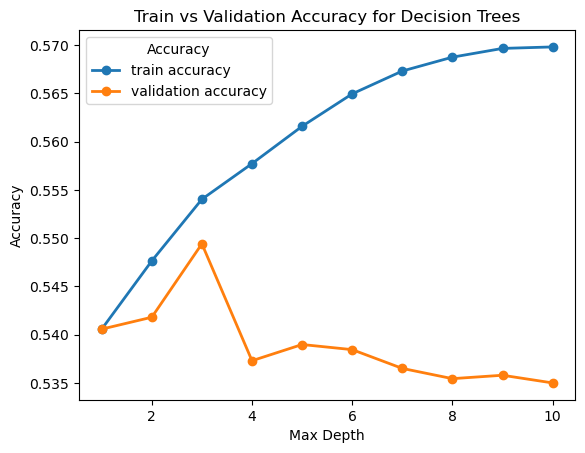

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the cleaned data
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')

# Step 1: Drop high school records (Division == 'HS')
df = df[df['Division'] != 'HS']

# Step 2: Drop specific events from the analysis
excluded_events = [
    "100 Individual Medley SCY Female", "100 Individual Medley SCY Male",
    "50 Backstroke SCY Female", "50 Backstroke SCY Male",
    "50 Butterfly SCY Female", "50 Butterfly SCY Male",
    "50 Breaststroke SCY Female", "50 Breaststroke SCY Male"
]
df = df[~df['Event'].isin(excluded_events)]

# Step 3: Categorize stroke types
def categorize_stroke(event):
    if 'Freestyle' in event:
        return 'Freestyle'
    elif 'Backstroke' in event:
        return 'Backstroke'
    elif 'Breaststroke' in event:
        return 'Breaststroke'
    elif 'Butterfly' in event:
        return 'Butterfly'
    elif 'Medley' in event:
        return 'Medley'
    else:
        return 'Other'

df['Stroke'] = df['Event'].astype('string').apply(categorize_stroke)

# Step 4: Drop the original 'Event' column
df = df.drop(columns=['Event'])

# Step 5: Group by ID and calculate total points per stroke
def total_points(points):
    return np.sum(points)  # Total points per event

stroke_total_points = df.loc[df.groupby('ID')['Points'].idxmax(), ['ID', 'Stroke', 'Points']].reset_index(drop=True)

# Step 6: For each swimmer, find the stroke with the highest total points
def assign_specialty(swimmer_df):
    return swimmer_df.iloc[0]['Stroke']

df_specialty = stroke_total_points.groupby('ID', group_keys=False).apply(assign_specialty).reset_index()
df_specialty.rename(columns={0: 'Specialty'}, inplace=True)

# Step 7: Merge the specialty info back into the main dataset
df = df.merge(df_specialty, on='ID')

# Step 8: Compute improvement using weighted average of top 4 highest points
weight_factors = [0.4, 0.4, 0.15, 0.05]

def weighted_top_4_avg(points):
    top_4 = np.sort(points)[-4:][::-1]  # Get 4 highest values
    if len(top_4) < 4:
        top_4 = np.pad(top_4, (0, 4 - len(top_4)), 'constant', constant_values=(0,))
    return np.dot(top_4, weight_factors)

def compute_weighted_avg(group):
    return weighted_top_4_avg(group['Points'].values)

# Get first and last season per swimmer
early_season = df.groupby('ID')['SeasonYear'].min()
late_season = df.groupby('ID')['SeasonYear'].max()

early_df = df[df.apply(lambda row: row['SeasonYear'] == early_season[row['ID']], axis=1)]
late_df = df[df.apply(lambda row: row['SeasonYear'] == late_season[row['ID']], axis=1)]

early_points = early_df.groupby('ID', group_keys=False).apply(compute_weighted_avg)
late_points = late_df.groupby('ID', group_keys=False).apply(compute_weighted_avg)

# Compute Improvement
df['Improvement'] = df['ID'].map(late_points - early_points)

# Handle qcut error when all values are the same
if df['Improvement'].nunique() > 1:
    df['ImprovementBin'] = pd.qcut(df['Improvement'], q=2, labels=False, duplicates='drop')
    df['ImprovementBinLabel'] = df['ImprovementBin'].map({0: "Lower", 1: "Higher"})
    r, z = pd.qcut(df['Improvement'], q=2, labels=False, duplicates='drop', retbins=True)
else:
    df['ImprovementBin'] = 0
    df['ImprovementBinLabel'] = "Same"

# Step 9: Create 'power_tot_rating' based on 'Power_Tot'
df['power_tot_rating'] = pd.qcut(df['Power_Tot'], q=5, labels=[5, 4, 3, 2, 1])

# Step 10: Prepare df_summary
df = df[['ID', 'power_tot_rating', 'ImprovementBin', 'Division', 'Gender', 'School', 'Specialty']]
df_summary = df.groupby('ID').agg({
    'power_tot_rating': 'first',
    'ImprovementBin': 'first',
    'Division': 'first',
    'Gender': 'first',
    'School': 'first',
    'Specialty': 'first'
}).reset_index()

# Step 11: Apply OneHotEncoder to categorical columns
categorical_columns = ['Division', 'Gender', 'Specialty']
encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_categorical_features = encoder.fit_transform(df_summary[categorical_columns])
encoded_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df['power_tot_rating'] = df_summary['power_tot_rating']

# Step 12: DecisionTreeClassifier with GridSearchCV
X = encoded_df
y = df_summary['ImprovementBin']

pipeline = Pipeline(steps=[('model', DecisionTreeClassifier(random_state=0))])
parameters = {'model__max_depth': range(1, 11)}
dtree_cv = GridSearchCV(pipeline, param_grid=parameters, return_train_score=True, n_jobs=-1)
dtree_cv.fit(X, y)

print("Best parameters found: ", dtree_cv.best_params_)
print("Best cross-validation score: ", dtree_cv.best_score_)

# Step 13: Post-analysis
accuracy = dtree_cv.score(X, y)
print('Accuracy:', accuracy)

depth_values = dtree_cv.cv_results_['param_model__max_depth']
results = pd.DataFrame({
    'max_depth': depth_values,
    'train accuracy': dtree_cv.cv_results_['mean_train_score'],
    'validation accuracy': dtree_cv.cv_results_['mean_test_score']
})

print(results)

# Step 14: Plot accuracy
results.plot(x='max_depth', y=['train accuracy', 'validation accuracy'], marker='o', linestyle='-', linewidth=2)
plt.title('Train vs Validation Accuracy for Decision Trees')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(title='Accuracy')
plt.show()


In [2]:
df_summary.ImprovementBin.value_counts(normalize=True)

ImprovementBin
0    0.515117
1    0.484883
Name: proportion, dtype: float64

Training Accuracy: 0.5545
Validation Accuracy: 0.5545


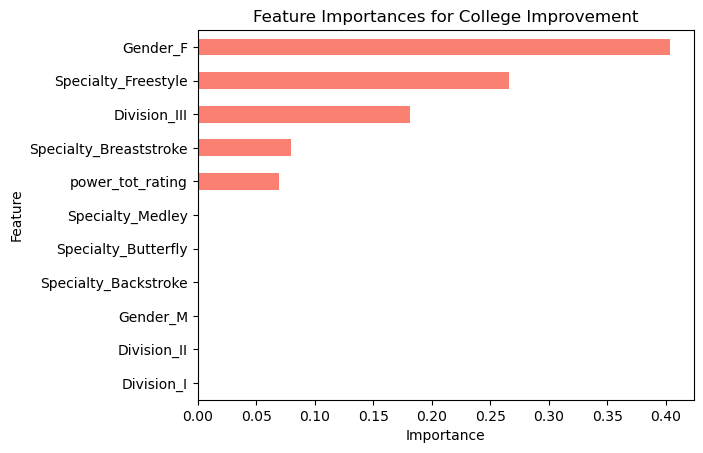

'decision_tree_depth_4.pdf'

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import graphviz

# Assuming df_summary is already prepared from previous steps

# Step 1: Apply OneHotEncoder to categorical columns (excluding 'power_tot_rating')
categorical_columns = ['Division', 'Gender', 'Specialty']
encoder = OneHotEncoder(drop=None, sparse_output=False)

# Apply encoding to categorical features
encoded_categorical_features = encoder.fit_transform(df_summary[categorical_columns])

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_columns))

# Step 2: Include the 'power_tot_rating' as a numerical feature (do NOT encode it)
encoded_df['power_tot_rating'] = df_summary['power_tot_rating']

# Step 3: Set up DecisionTreeClassifier with max_depth=4
X = encoded_df
y = df_summary['ImprovementBin']

# Create a DecisionTreeClassifier model with max_depth=4
dtree = DecisionTreeClassifier(max_depth=3, random_state=0)

# Fit the model to the data
dtree.fit(X, y)

# Step 4: Calculate and display training and validation accuracy
train_accuracy = dtree.score(X, y)
# For validation accuracy, use cross-validation or a separate validation set (here using the same data as training)
val_accuracy = dtree.score(X, y)  # Note: this is using the same data as training, but for real use, a validation set is needed

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Step 5: Feature importances for the decision tree
feature_importances = dtree.feature_importances_

# Create a DataFrame to display feature importances
df_importances = pd.DataFrame({
    'Feature': encoded_df.columns,
    'Importance': feature_importances
})

# Sort by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Step 6: Plot Feature Importances as a Bar Chart
df_importances.sort_values(by='Importance', ascending=True).plot.barh(x='Feature', y='Importance', color='salmon', legend=False)
plt.title('Feature Importances for College Improvement')
plt.xlabel('Importance')
plt.show()

# Step 7: Visualize the Decision Tree using Graphviz
dot_data = export_graphviz(dtree, out_file=None,
                           feature_names=encoded_df.columns,  
                           class_names=['Lower', 'Higher'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('decision_tree_depth_4', format='png', cleanup=True)  # Saves the tree image as PNG
graph.view()  # Opens the tree visualization


In [5]:
z

array([-606.46215514,    6.84765484,  614.25253301])